## Different Classifier Models: Practicality, Performance and Use Cases
 
**Data** [Sources](2_Data_Sources.ipynb) | [Compositional Data](2_Data_CompositionalData.ipynb) | [Lambdas](2_Data_Lambdas.ipynb) **Classifiers** [Models](3_Classifiers_ClassifierModels.ipynb) | [Dimensionality](3_Classifiers_Dimensionality.ipynb) | [Performance](3_Classifiers_Performance.ipynb) **Visualisation**  [Entropy](4_Vis_Entropy.ipynb) | [Manifolds](4_Vis_Manifolds.ipynb) **Workflows** [Building Workflows](5_BuildingWorkflows.ipynb) **pyrolite** [Overview](6_pyrolite.ipynb) **GitHub** [AEGC2019](https://github.com/morganjwilliams/aegc2019) | [pyrolite](https://github.com/morganjwilliams/pyrolite)

This notebook introduces some of the classifier models which have been used previously for geochemical tectonic discrimination, and provides minimal working examples for building a working model. Clasification models used for tectonic discrimination using bulk-rock geochemical data include support vector classifiers, random forests and sparse multinomial regression ([Petrelli2016], [Ueki2018]). Here we'll rebuild some of these classifiers, working from the simplest possible implementations through to optimised classifiers ready to be put to work.

[Petrelli2016]: https://doi.org/10.1007/s00410-016-1292-2 "Petrelli, M., Perugini, D., 2016. Solving petrological problems through machine learning: the study case of tectonic discrimination using geochemical and isotopic data. Contrib Mineral Petrol 171, 81."
[Ueki2018]: https://doi.org/10.1029/2017GC007401 "Ueki, K., Hino, H., Kuwatani, T., 2018. Geochemical Discrimination and Characteristics of Magmatic Tectonic Settings: A Machine-Learning-Based Approach. Geochemistry, Geophysics, Geosystems 19, 1327–1347."

First we'll import some general libraries which we'll use throughout, including numpy, pandas and matplotlib ([Oliphant2006], [vanderWalt2011], [McKinney2010], [Hunter2007]). We'll use scikit-learn for the majority of machine learning tasks ([Pedregosa2011]).

[Oliphant2006]: https://numpy.org/ "Oliphant, T.E., 2006. A guide to NumPy. Trelgol Publishing USA."

[vanderWalt2011]: https://numpy.org/ "van der Walt, S., Colbert, S.C., Varoquaux, G., 2011. The NumPy Array: A Structure for Efficient Numerical Computation. Computing in Science Engineering 13, 22–30. https://doi.org/10.1109/MCSE.2011.37"

[Hunter2007]: https://matplotlib.org/ "Hunter, J.D., 2007. Matplotlib: A 2D Graphics Environment. Comput. Sci. Eng. 9, 90–95. https://doi.org/10.1109/MCSE.2007.55"

[McKinney2010]: https://pandas.pydata.org/pandas-docs/stable/ "McKinney, W., 2010. Data structures for statistical computing in python, in: van der Walt, S., Millman, J. (Eds.), Proceedings of the 9th Python in Science Conference. pp. 51–56."

[Pedregosa2011]: https://scikit-learn.org/ "Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, É., 2011. Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research 12, 2825−2830."

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
# could also use imblearn.pipleline.make_pipeline

pyrolite also provides a number of useful functions here, especially for using geochemical data ([Williams2019]).

[Williams2019]: https://pyrolite.rtfd.io "Williams, M., 2019. pyrolite: A set of tools for getting the most from your geochemical data. http://dx.doi.org/10.5281/zenodo.2545106"



In [3]:
from pyrolite.geochem.ind import common_elements, common_oxides

from pyrolite.util.skl.vis import plot_confusion_matrix
from pyrolite.util.skl.pipeline import SVC_pipeline, PdUnion
from pyrolite.util.skl.select import CompositionalSelector
from pyrolite.util.skl.transform import CLRTransform, LinearTransform

Using TensorFlow backend.


As for the majority of this set of notebooks, we'll use the 29-dimension tectonic discrimination dataset (majors, minors, traces and isotopes) from Ueki et al. (2018), modified to list the specific tectonic setting in a 'Class' column. Tectonic setting classes are as follows: 
   * BAB: Back Arc Basin
   * CA: Continental Arc
   * CFB: Continental Flood Basalt
   * IA: Island Arc
   * IOA: Intra-oceanic Arc
   * MOR: Mid-Ocean Ridge
   * OI: Ocean Island
   * OP: Oceanic Plateau.

In [4]:
df = pd.read_csv('https://storage.googleapis.com/aegc2019/ueki2018.csv')

compositional_variables = common_elements(as_set=True) | common_oxides(as_set=True)
abundances = [i for i in df.columns if i in compositional_variables]
isotopes = [i for i in df.columns if i != "Class" and i not in compositional_variables]

classes = list(df.Class.unique())
classes

['CA', 'IA', 'IOA', 'BAB', 'CFB', 'MOR', 'OP', 'OI']

To make this dataset suitable for use to train a classifier, let's first split the features from the true classes and then scale the training data such that each column falls in the range \\([-1, 1]\\). 

In [5]:
X, y = df.loc[:, abundances + isotopes], df["Class"]

In [6]:
scaler = StandardScaler()
X_ = scaler.fit_transform(X)

To assess the performance of our classifier, we'll need to hold back an independent subset of the data for testing purposes. Here we reserve 30% of the data for testing, and ensure that it will proportionately contain data for each of our classes.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, test_size=0.3)

### Support Vector Classifiers

In [8]:
clf = SVC()
clf.fit(X_train, y_train);

In [9]:
svcscore = clf.score(X_test, y_test)
"Overall Accuracy: {:.1f}%".format(svcscore*100)

'Overall Accuracy: 88.4%'

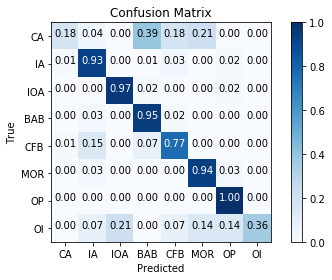

In [10]:
plot_confusion_matrix(clf, X_test, y_test, normalize=True, classes=classes);

### Random Forests

In [11]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=4)
rf.fit(X_train, y_train);

In [12]:
rfscore = rf.score(X_test, y_test)
"Overall Accuracy: {:.1f}%".format(rfscore*100)

'Overall Accuracy: 81.7%'

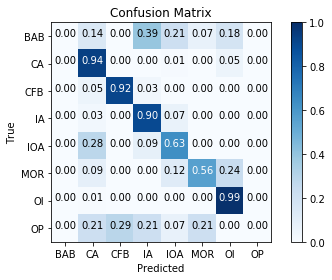

In [13]:
plot_confusion_matrix(rf, X_test, y_test, normalize=True);

Random forests can be used to investigate relative importance of features:

In [14]:
ft_importances = pd.DataFrame(data=np.round(rf.feature_importances_,3), 
                              columns=['Importance'], index=X.columns
                             ).sort_values('Importance', ascending=False) * 100
ft_importances[:6]

,Importance
Sr87Sr86,11.8
TiO2,9.8
Nb,9.0
Ta,6.8
Nd143Nd144,6.6
Sr,5.4


### Multinomial Logistic Regressions

In [15]:
lr = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr.fit(X_train, y_train);

In [16]:
lrscore = lr.score(X_test, y_test)
"Overall Accuracy: {:.1f}%".format(lrscore*100)

'Overall Accuracy: 88.9%'

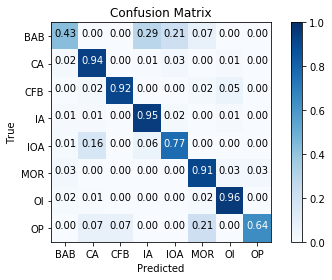

In [17]:
plot_confusion_matrix(lr, X_test, y_test, normalize=True);

In [18]:
probs = pd.DataFrame(data=lr.predict_proba(X_test[:8, :]), columns=lr.classes_) * 100
probs["Expect"] = y_test[:8].tolist()
table = probs[probs.columns[::-1]].round(2)
table.style.background_gradient(cmap="Blues", axis=1)

,Expect,OP,OI,MOR,IOA,IA,CFB,CA,BAB
0,IOA,0.46,0,0.29,87.29,1.67,0,1.52,8.77
1,IOA,0,0.02,0,15.45,0.77,0,83.33,0.42
2,CFB,1.97,0.31,0.01,0,0,97.69,0.02,0
3,IA,0.3,0,0.64,1.66,96.03,0.02,0.21,1.14
4,OI,1.32,22.05,1.86,8.56,12.44,0.13,32.56,21.08
5,IOA,0.13,0,1.45,73.09,10.53,0,4.66,10.13
6,CA,0,0,0,33.21,6.82,0,58.6,1.36
7,OI,0.02,99.1,0.01,0,0,0.06,0.8,0.02


### An Extended Workflow for Support Vector Classifiers: Gridsearch for Parameter Optimisation

In [19]:
preprocessor = PdUnion(
    [
        make_pipeline(CompositionalSelector(), CLRTransform()),
        make_pipeline(CompositionalSelector(inverse=True), LinearTransform()),
    ]
)
XX_ = StandardScaler().fit_transform(preprocessor.fit_transform(X))

In [20]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX_, y, stratify=y, test_size=0.3)

We can see how this preprocessing improves our other simple classifiers:

In [21]:
lr2 = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr2.fit(XX_train, yy_train)
lr2score = lr2.score(XX_test, yy_test) 

In [22]:
rf2 = RandomForestClassifier()
rf2.fit(XX_train, yy_train)
rf2score = rf2.score(XX_test, yy_test)

In [23]:
svc2 = SVC(kernel='rbf')
svc2.fit(XX_train, yy_train)
svc2score = svc2.score(XX_test, yy_test)

Now we can build an optimised classifier, in this case using a pipeline constructor from pyrolite:

In [24]:
gs = SVC_pipeline(verbose=1,
                  probability=True,  # Use Platt scaling to give estimates of probabilistic output
                  param_grid=dict(
                      svc__gamma=np.logspace(-2.3, -0.85, 5),
                      svc__C=np.logspace(-0.5, 2, 5),  # limit C parameter to avoid overfitting
                  ))
gs.fit(XX_train, yy_train);

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   40.7s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   49.4s finished


In [25]:
svcgsscore = gs.best_estimator_.score(XX_test, yy_test)
"Overall Accuracy: {:.1f}%".format(svcgsscore*100)

'Overall Accuracy: 95.3%'

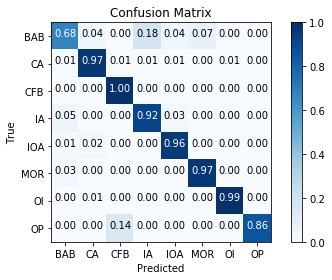

In [26]:
plot_confusion_matrix(
    gs.best_estimator_, XX_test, yy_test, normalize=True
);

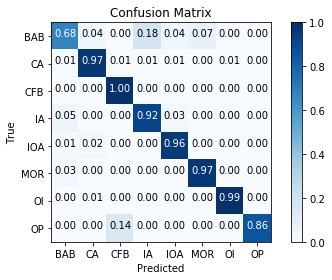

In [27]:
from pyrolite.util.plot import save_figure
save_figure(plot_confusion_matrix(
    gs.best_estimator_, XX_test, yy_test, normalize=True
).figure, name='GS_SVC_ConfMatrix', save_fmts=['pdf', 'png'])

In [28]:
probs = (
    pd.DataFrame(
        data=gs.best_estimator_.predict_proba(XX_test[:8]),
        columns=gs.best_estimator_.classes_,
    )
    * 100
)
probs["Expect"] = yy_test[:8].tolist()
table = probs[probs.columns[::-1]].round(2)
table.style.background_gradient(cmap="Blues", axis=1)

,Expect,OP,OI,MOR,IOA,IA,CFB,CA,BAB
0,CA,0.02,0,0,0.29,0.03,0.01,99.59,0.07
1,CFB,0.38,1.79,30.51,0.75,0.49,58.13,1.41,6.54
2,IA,2.38,2.69,0.85,7.64,42.29,2.42,40.2,1.53
3,OI,0.04,99.8,0.02,0.04,0.04,0.03,0.01,0.02
4,CA,0.08,0.08,0.02,3.33,0.68,0.11,94.62,1.09
5,IOA,0.15,0.06,0.08,96.53,1.01,0.22,1.4,0.56
6,CFB,2.39,1.39,0.45,2.26,0.63,90.44,1,1.44
7,IA,0.57,0.17,0.94,8.27,74.11,0.2,0.44,15.3


In [29]:
scores = [(svcscore, svc2score, svcgsscore), 
                               (rfscore, rf2score, np.nan), 
                               (lrscore, lr2score, np.nan)]
results = pd.DataFrame(data = scores, 
                       columns=['Start', "With CLR", 'GridSearch'], 
                       index = ['SVC', 'RandomForest', 'Logist.Reg.']
                      ).round(3) *100
results.style.format(lambda x: "{:.1f}%".format(x) if not np.isnan(x) else ""
                    ).background_gradient(cmap="Greens",
                                          low=0, 
                                          high=1, 
                                          axis=None)

,Start,With CLR,GridSearch
SVC,88.4%,90.5%,95.3%
RandomForest,81.7%,88.6%,
Logist.Reg.,88.9%,88.8%,
